# Importing required Libraries

In [1]:
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import signal

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Files

In [2]:
pwd

'/Users/ad/Downloads/FYP'

In [3]:
mypath ='/Users/ad/Downloads/FYP/audio_and_txt_files/'
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [4]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [5]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [6]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [8]:
p_diag = pd.read_csv('/Users/ad/Downloads/FYP/patient_diagnosis.csv',header=None) # patient diagnosis file

In [9]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

# Extracting Features

In [10]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)
index_num=[]
other_num=[]
for n in range (0,920):
    if labels[n]=='COPD':
        index_num.append(n)
    else:
        other_num.append(n)
arr=[]
for i in range(0,100):
    n=random.choice(index_num)
    arr.append(n)
features2=[]
for item in arr:
    features2.append(features[item])
for item in other_num:
    features2.append(features[item])

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)
features2=np.array(features2)

Finished feature extraction from  920  files


In [11]:
np.array(labels).tolist()
labels2=[]
for item in arr:
    labels2.append(labels[item])
for item in other_num:
    labels2.append(labels[item])

In [12]:
labels=np.array(labels)
labels2=np.array(labels2)

In [42]:
print (len(features[10]))

40


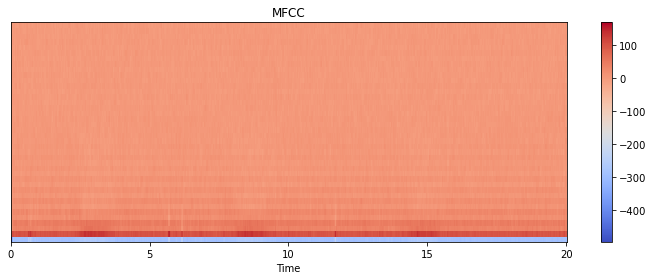

In [13]:
#plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features2[10], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [14]:
features2.shape

(227, 40, 862)

In [15]:
# print class counts
unique_elements, counts_elements = np.unique(labels2, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['1' '16' '13' '100' '35' '2' '37' '23']]


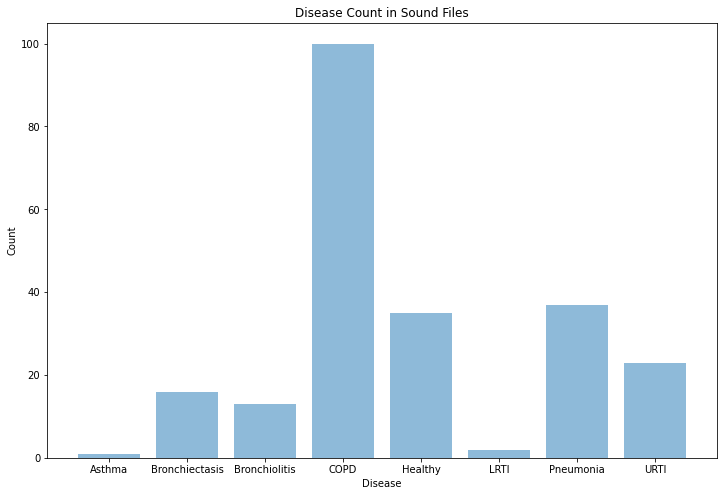

In [16]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

# Remove the data with least cases

In [17]:
features1 = np.delete(features2, np.where((labels2 == 'Asthma') | (labels2 == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels2, np.where((labels2 == 'Asthma') | (labels2 == 'LRTI'))[0], axis=0)

In [18]:
features1.shape

(224, 40, 862)

# Designing Neural Network

In [19]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels)

In [20]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1))

In [89]:
features1.shape

(224, 40, 862, 1)

In [21]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [22]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Dense(num_labels, activation='softmax'))

In [23]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [24]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

# Training the model

In [74]:
# train model
num_epochs = 1000
num_batch_size = 32

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/1000
6/6 [==============================] - 2s 251ms/step - loss: 6.9285e-04 - accuracy: 1.0000 - val_loss: 3.0169 - val_accuracy: 0.6667

Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to mymodel2_01.h5
Epoch 2/1000
6/6 [==============================] - 1s 239ms/step - loss: 0.0254 - accuracy: 0.9832 - val_loss: 2.6954 - val_accuracy: 0.6889

Epoch 00002: val_accuracy improved from 0.66667 to 0.68889, saving model to mymodel2_02.h5
Epoch 3/1000
6/6 [==============================] - 1s 237ms/step - loss: 0.1268 - accuracy: 0.9609 - val_loss: 3.0911 - val_accuracy: 0.6444

Epoch 00003: val_accuracy did not improve from 0.68889
Epoch 4/1000
6/6 [==============================] - 1s 249ms/step - loss: 0.3016 - accuracy: 0.9162 - val_loss: 2.4475 - val_accuracy: 0.6667

Epoch 00004: val_accuracy did not improve from 0.68889
Epoch 5/1000
6/6 [==============================] - 1s 238ms/step - loss: 1.1699 - accuracy: 0.8324 - val_loss: 2.5438 - val_accuracy: 

6/6 [==============================] - 2s 282ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.4889 - val_accuracy: 0.7111

Epoch 00082: val_accuracy did not improve from 0.75556
Epoch 83/1000
6/6 [==============================] - 2s 277ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.4291 - val_accuracy: 0.7111

Epoch 00083: val_accuracy did not improve from 0.75556
Epoch 84/1000
6/6 [==============================] - 2s 298ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.2457 - val_accuracy: 0.7333

Epoch 00084: val_accuracy did not improve from 0.75556
Epoch 85/1000
6/6 [==============================] - 2s 286ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.2726 - val_accuracy: 0.7333

Epoch 00085: val_accuracy did not improve from 0.75556
Epoch 86/1000
6/6 [==============================] - 2s 290ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.3009 - val_accuracy: 0.7333

Epoch 00086: val_accuracy did not improve from 0.75556
Epoch 87/1000
6/6 [

6/6 [==============================] - 2s 295ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.7821 - val_accuracy: 0.7333

Epoch 00164: val_accuracy did not improve from 0.75556
Epoch 165/1000
6/6 [==============================] - 2s 299ms/step - loss: 0.0111 - accuracy: 0.9944 - val_loss: 1.8160 - val_accuracy: 0.7333

Epoch 00165: val_accuracy did not improve from 0.75556
Epoch 166/1000
6/6 [==============================] - 2s 292ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.9415 - val_accuracy: 0.7333

Epoch 00166: val_accuracy did not improve from 0.75556
Epoch 167/1000
6/6 [==============================] - 2s 291ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 2.0202 - val_accuracy: 0.7111

Epoch 00167: val_accuracy did not improve from 0.75556
Epoch 168/1000
6/6 [==============================] - 2s 284ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.1474 - val_accuracy: 0.7111

Epoch 00168: val_accuracy did not improve from 0.75556
Epoch 169/1000


6/6 [==============================] - 2s 299ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 1.8889 - val_accuracy: 0.7111

Epoch 00205: val_accuracy did not improve from 0.75556
Epoch 206/1000
6/6 [==============================] - 2s 288ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 2.1703 - val_accuracy: 0.6889

Epoch 00206: val_accuracy did not improve from 0.75556
Epoch 207/1000
6/6 [==============================] - 2s 289ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 2.1945 - val_accuracy: 0.6889

Epoch 00207: val_accuracy did not improve from 0.75556
Epoch 208/1000
6/6 [==============================] - 2s 290ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 2.0504 - val_accuracy: 0.7333

Epoch 00208: val_accuracy did not improve from 0.75556
Epoch 209/1000
6/6 [==============================] - 2s 283ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.9224 - val_accuracy: 0.7333

Epoch 00209: val_accuracy did not improve from 0.75556
Epoch 210/1000


6/6 [==============================] - 2s 325ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.5163 - val_accuracy: 0.7556

Epoch 00246: val_accuracy did not improve from 0.75556
Epoch 247/1000
6/6 [==============================] - 2s 332ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.5261 - val_accuracy: 0.7556

Epoch 00247: val_accuracy did not improve from 0.75556
Epoch 248/1000
6/6 [==============================] - 2s 348ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.6345 - val_accuracy: 0.7556

Epoch 00248: val_accuracy did not improve from 0.75556
Epoch 249/1000
6/6 [==============================] - 2s 353ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.6761 - val_accuracy: 0.7556

Epoch 00249: val_accuracy did not improve from 0.75556
Epoch 250/1000
6/6 [==============================] - 2s 351ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.6476 - val_accuracy: 0.7556

Epoch 00250: val_accuracy did not improve from 0.75556
Epoch 251/1000


6/6 [==============================] - 2s 323ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.0372 - val_accuracy: 0.6889

Epoch 00287: val_accuracy did not improve from 0.75556
Epoch 288/1000
6/6 [==============================] - 2s 318ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.8773 - val_accuracy: 0.7111

Epoch 00288: val_accuracy did not improve from 0.75556
Epoch 289/1000
6/6 [==============================] - 2s 314ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.8406 - val_accuracy: 0.7111

Epoch 00289: val_accuracy did not improve from 0.75556
Epoch 290/1000
6/6 [==============================] - 2s 335ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.8903 - val_accuracy: 0.7333

Epoch 00290: val_accuracy did not improve from 0.75556
Epoch 291/1000
6/6 [==============================] - 2s 316ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.9318 - val_accuracy: 0.7333

Epoch 00291: val_accuracy did not improve from 0.75556
Epoch 292/1000



Epoch 00327: val_accuracy did not improve from 0.75556
Epoch 328/1000
6/6 [==============================] - 2s 378ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.0768 - val_accuracy: 0.6889

Epoch 00328: val_accuracy did not improve from 0.75556
Epoch 329/1000
6/6 [==============================] - 2s 379ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.1198 - val_accuracy: 0.6889

Epoch 00329: val_accuracy did not improve from 0.75556
Epoch 330/1000
6/6 [==============================] - 2s 379ms/step - loss: 6.9087e-04 - accuracy: 1.0000 - val_loss: 2.2559 - val_accuracy: 0.6889

Epoch 00330: val_accuracy did not improve from 0.75556
Epoch 331/1000
6/6 [==============================] - 2s 402ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.1819 - val_accuracy: 0.7333

Epoch 00331: val_accuracy did not improve from 0.75556
Epoch 332/1000
6/6 [==============================] - 2s 377ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.0875 - val_accuracy: 0.7

6/6 [==============================] - 2s 353ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.0330 - val_accuracy: 0.7333

Epoch 00409: val_accuracy did not improve from 0.77778
Epoch 410/1000
6/6 [==============================] - 2s 383ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.1740 - val_accuracy: 0.7333

Epoch 00410: val_accuracy did not improve from 0.77778
Epoch 411/1000
6/6 [==============================] - 2s 378ms/step - loss: 0.0081 - accuracy: 0.9944 - val_loss: 1.9644 - val_accuracy: 0.7333

Epoch 00411: val_accuracy did not improve from 0.77778
Epoch 412/1000
6/6 [==============================] - 2s 382ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.0584 - val_accuracy: 0.7111

Epoch 00412: val_accuracy did not improve from 0.77778
Epoch 413/1000
6/6 [==============================] - 2s 403ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 2.1635 - val_accuracy: 0.7111

Epoch 00413: val_accuracy did not improve from 0.77778
Epoch 414/1000


6/6 [==============================] - 2s 324ms/step - loss: 6.0985e-04 - accuracy: 1.0000 - val_loss: 2.4849 - val_accuracy: 0.7111

Epoch 00450: val_accuracy did not improve from 0.77778
Epoch 451/1000
6/6 [==============================] - 2s 331ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.4884 - val_accuracy: 0.7111

Epoch 00451: val_accuracy did not improve from 0.77778
Epoch 452/1000
6/6 [==============================] - 2s 329ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.5243 - val_accuracy: 0.7111

Epoch 00452: val_accuracy did not improve from 0.77778
Epoch 453/1000
6/6 [==============================] - 2s 322ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.5212 - val_accuracy: 0.7111

Epoch 00453: val_accuracy did not improve from 0.77778
Epoch 454/1000
6/6 [==============================] - 2s 337ms/step - loss: 8.2965e-04 - accuracy: 1.0000 - val_loss: 2.5350 - val_accuracy: 0.7111

Epoch 00454: val_accuracy did not improve from 0.77778
Epoch 4


Epoch 00490: val_accuracy did not improve from 0.77778
Epoch 491/1000
6/6 [==============================] - 2s 356ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.7004 - val_accuracy: 0.7333

Epoch 00491: val_accuracy did not improve from 0.77778
Epoch 492/1000
6/6 [==============================] - 2s 377ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.5640 - val_accuracy: 0.6889

Epoch 00492: val_accuracy did not improve from 0.77778
Epoch 493/1000
6/6 [==============================] - 2s 359ms/step - loss: 0.0086 - accuracy: 0.9944 - val_loss: 1.8054 - val_accuracy: 0.7333

Epoch 00493: val_accuracy did not improve from 0.77778
Epoch 494/1000
6/6 [==============================] - 2s 384ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.9261 - val_accuracy: 0.6889

Epoch 00494: val_accuracy did not improve from 0.77778
Epoch 495/1000
6/6 [==============================] - 3s 425ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.6546 - val_accuracy: 0.7111



Epoch 00531: val_accuracy did not improve from 0.77778
Epoch 532/1000
6/6 [==============================] - 2s 294ms/step - loss: 0.0104 - accuracy: 0.9944 - val_loss: 2.1340 - val_accuracy: 0.7111

Epoch 00532: val_accuracy did not improve from 0.77778
Epoch 533/1000
6/6 [==============================] - 2s 291ms/step - loss: 0.0330 - accuracy: 0.9944 - val_loss: 2.0334 - val_accuracy: 0.7111

Epoch 00533: val_accuracy did not improve from 0.77778
Epoch 534/1000
6/6 [==============================] - 2s 278ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 1.9787 - val_accuracy: 0.7333

Epoch 00534: val_accuracy did not improve from 0.77778
Epoch 535/1000
6/6 [==============================] - 2s 268ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 2.1315 - val_accuracy: 0.7333

Epoch 00535: val_accuracy did not improve from 0.77778
Epoch 536/1000
6/6 [==============================] - 2s 269ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.9540 - val_accuracy: 0.7333



Epoch 00612: val_accuracy did not improve from 0.80000
Epoch 613/1000
6/6 [==============================] - 2s 343ms/step - loss: 0.0131 - accuracy: 0.9944 - val_loss: 2.4418 - val_accuracy: 0.7333

Epoch 00613: val_accuracy did not improve from 0.80000
Epoch 614/1000
6/6 [==============================] - 2s 339ms/step - loss: 0.0254 - accuracy: 0.9944 - val_loss: 1.9971 - val_accuracy: 0.7556

Epoch 00614: val_accuracy did not improve from 0.80000
Epoch 615/1000
6/6 [==============================] - 2s 323ms/step - loss: 8.0496e-04 - accuracy: 1.0000 - val_loss: 1.7212 - val_accuracy: 0.7111

Epoch 00615: val_accuracy did not improve from 0.80000
Epoch 616/1000
6/6 [==============================] - 2s 312ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.7889 - val_accuracy: 0.7333

Epoch 00616: val_accuracy did not improve from 0.80000
Epoch 617/1000
6/6 [==============================] - 2s 321ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.2559 - val_accuracy: 0.7


Epoch 00653: val_accuracy did not improve from 0.80000
Epoch 654/1000
6/6 [==============================] - 2s 280ms/step - loss: 0.0108 - accuracy: 0.9944 - val_loss: 1.9448 - val_accuracy: 0.7111

Epoch 00654: val_accuracy did not improve from 0.80000
Epoch 655/1000
6/6 [==============================] - 2s 285ms/step - loss: 8.4533e-04 - accuracy: 1.0000 - val_loss: 1.8416 - val_accuracy: 0.7111

Epoch 00655: val_accuracy did not improve from 0.80000
Epoch 656/1000
6/6 [==============================] - 2s 319ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.8158 - val_accuracy: 0.7111

Epoch 00656: val_accuracy did not improve from 0.80000
Epoch 657/1000
6/6 [==============================] - 2s 294ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 1.9628 - val_accuracy: 0.6889

Epoch 00657: val_accuracy did not improve from 0.80000
Epoch 658/1000
6/6 [==============================] - 2s 279ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 2.0591 - val_accuracy: 0.7


Epoch 00694: val_accuracy did not improve from 0.80000
Epoch 695/1000
6/6 [==============================] - 2s 319ms/step - loss: 0.0181 - accuracy: 0.9888 - val_loss: 2.0841 - val_accuracy: 0.7111

Epoch 00695: val_accuracy did not improve from 0.80000
Epoch 696/1000
6/6 [==============================] - 2s 332ms/step - loss: 0.0282 - accuracy: 0.9888 - val_loss: 1.7229 - val_accuracy: 0.7556

Epoch 00696: val_accuracy did not improve from 0.80000
Epoch 697/1000
6/6 [==============================] - 2s 322ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 1.5756 - val_accuracy: 0.7778

Epoch 00697: val_accuracy did not improve from 0.80000
Epoch 698/1000
6/6 [==============================] - 2s 319ms/step - loss: 0.0152 - accuracy: 0.9944 - val_loss: 1.8018 - val_accuracy: 0.7333

Epoch 00698: val_accuracy did not improve from 0.80000
Epoch 699/1000
6/6 [==============================] - 2s 317ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.9916 - val_accuracy: 0.7556



Epoch 00735: val_accuracy did not improve from 0.80000
Epoch 736/1000
6/6 [==============================] - 2s 302ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.1608 - val_accuracy: 0.7333

Epoch 00736: val_accuracy did not improve from 0.80000
Epoch 737/1000
6/6 [==============================] - 2s 294ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.0934 - val_accuracy: 0.7556

Epoch 00737: val_accuracy did not improve from 0.80000
Epoch 738/1000
6/6 [==============================] - 2s 287ms/step - loss: 9.1140e-04 - accuracy: 1.0000 - val_loss: 2.0581 - val_accuracy: 0.7556

Epoch 00738: val_accuracy did not improve from 0.80000
Epoch 739/1000
6/6 [==============================] - 2s 303ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.0190 - val_accuracy: 0.7333

Epoch 00739: val_accuracy did not improve from 0.80000
Epoch 740/1000
6/6 [==============================] - 2s 289ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.0138 - val_accuracy: 0.7

6/6 [==============================] - 2s 331ms/step - loss: 6.8374e-04 - accuracy: 1.0000 - val_loss: 2.2797 - val_accuracy: 0.7333

Epoch 00816: val_accuracy did not improve from 0.80000
Epoch 817/1000
6/6 [==============================] - 2s 312ms/step - loss: 2.1950e-04 - accuracy: 1.0000 - val_loss: 2.2964 - val_accuracy: 0.7333

Epoch 00817: val_accuracy did not improve from 0.80000
Epoch 818/1000
6/6 [==============================] - 2s 309ms/step - loss: 8.7265e-04 - accuracy: 1.0000 - val_loss: 2.3801 - val_accuracy: 0.7333

Epoch 00818: val_accuracy did not improve from 0.80000
Epoch 819/1000
6/6 [==============================] - 2s 306ms/step - loss: 7.5894e-04 - accuracy: 1.0000 - val_loss: 2.4680 - val_accuracy: 0.7111

Epoch 00819: val_accuracy did not improve from 0.80000
Epoch 820/1000
6/6 [==============================] - 2s 297ms/step - loss: 2.7448e-04 - accuracy: 1.0000 - val_loss: 2.5006 - val_accuracy: 0.7111

Epoch 00820: val_accuracy did not improve from 0.8

6/6 [==============================] - 2s 307ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 1.7600 - val_accuracy: 0.6889

Epoch 00897: val_accuracy did not improve from 0.80000
Epoch 898/1000
6/6 [==============================] - 2s 304ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.8173 - val_accuracy: 0.7333

Epoch 00898: val_accuracy did not improve from 0.80000
Epoch 899/1000
6/6 [==============================] - 2s 339ms/step - loss: 0.0232 - accuracy: 0.9888 - val_loss: 1.7977 - val_accuracy: 0.7111

Epoch 00899: val_accuracy did not improve from 0.80000
Epoch 900/1000
6/6 [==============================] - 2s 369ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.4622 - val_accuracy: 0.7111

Epoch 00900: val_accuracy did not improve from 0.80000
Epoch 901/1000
6/6 [==============================] - 2s 326ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.3757 - val_accuracy: 0.7333

Epoch 00901: val_accuracy did not improve from 0.80000
Epoch 902/1000


6/6 [==============================] - 2s 313ms/step - loss: 4.6003e-04 - accuracy: 1.0000 - val_loss: 1.7081 - val_accuracy: 0.7556

Epoch 00938: val_accuracy did not improve from 0.80000
Epoch 939/1000
6/6 [==============================] - 2s 319ms/step - loss: 3.7184e-04 - accuracy: 1.0000 - val_loss: 1.7034 - val_accuracy: 0.7556

Epoch 00939: val_accuracy did not improve from 0.80000
Epoch 940/1000
6/6 [==============================] - 2s 346ms/step - loss: 4.6958e-04 - accuracy: 1.0000 - val_loss: 1.7022 - val_accuracy: 0.7556

Epoch 00940: val_accuracy did not improve from 0.80000
Epoch 941/1000
6/6 [==============================] - 2s 301ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.7571 - val_accuracy: 0.7556

Epoch 00941: val_accuracy did not improve from 0.80000
Epoch 942/1000
6/6 [==============================] - 2s 304ms/step - loss: 5.0856e-04 - accuracy: 1.0000 - val_loss: 1.7815 - val_accuracy: 0.7556

Epoch 00942: val_accuracy did not improve from 0.80000

# Summarize History for accuracy

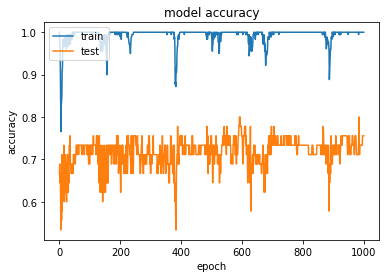

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize History for Loss

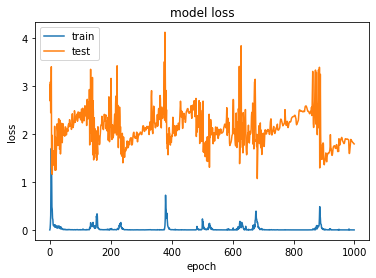

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.7555555701255798


In [78]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

In [79]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [80]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

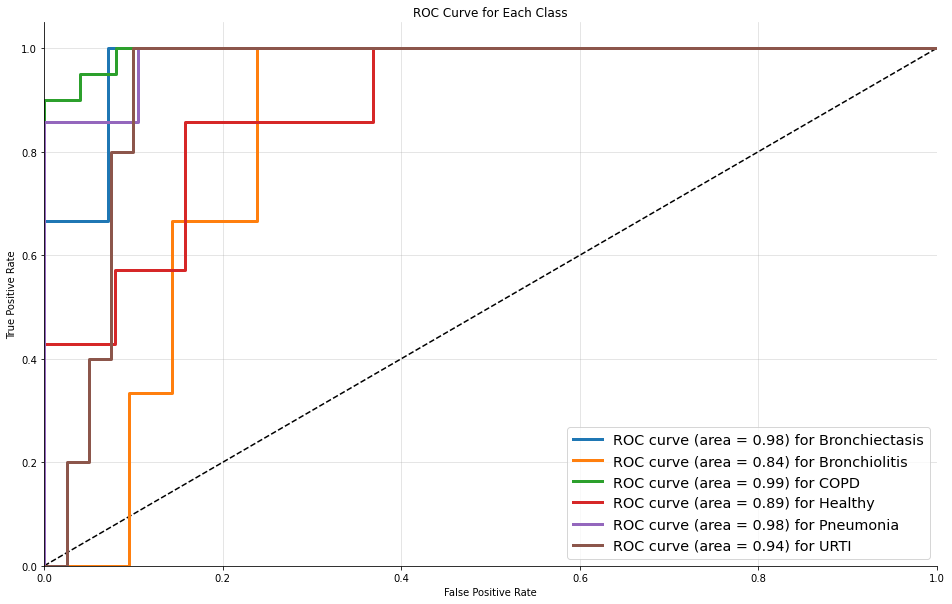

In [81]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [82]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       1.00      0.33      0.50         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.91      1.00      0.95        20
       Healthy       0.57      0.57      0.57         7
     Pneumonia       0.67      0.86      0.75         7
          URTI       0.50      0.60      0.55         5

      accuracy                           0.76        45
     macro avg       0.61      0.56      0.55        45
  weighted avg       0.72      0.76      0.72        45



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[ 1  0  0  0  2  0]
 [ 0  0  1  0  1  1]
 [ 0  0 20  0  0  0]
 [ 0  0  1  4  0  2]
 [ 0  0  0  1  6  0]
 [ 0  0  0  2  0  3]]


In [125]:
file_name='/Users/ad/Downloads/FYP/out2.wav'
audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
pad_width = max_pad_len - mfccs.shape[1]
mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

In [126]:
mfccs.shape

(40, 862)

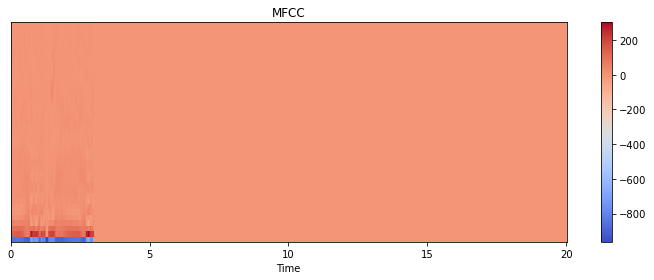

In [127]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [128]:
feature=[mfccs]
feature=np.array(feature)
feature=np.reshape(feature,(*feature.shape,1))
feature.shape

(1, 40, 862, 1)

In [129]:
y=model.predict(feature)
z = np.argmax(y, axis=1)
np.array(z).tolist()
z=z[0]
c_names[z]

'URTI'